In [1]:
import pandas as pd
import numpy as np
import datetime
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm
import torch.nn.functional as F
from FirthLogit import Firth_Logit
from imblearn.over_sampling import SMOTE
import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random
from keras import regularizers
from keras import models,layers,optimizers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(rc = {'figure.figsize':(8,5)})
from sklearn.preprocessing import OneHotEncoder


Using TensorFlow backend.


# Preprocessing & Feature Engineering

In [3]:
df = pd.read_csv('creditcard.csv')
y = df.Class

0.172% of transactions in the dataset are fraudulent

### Transaction Amount

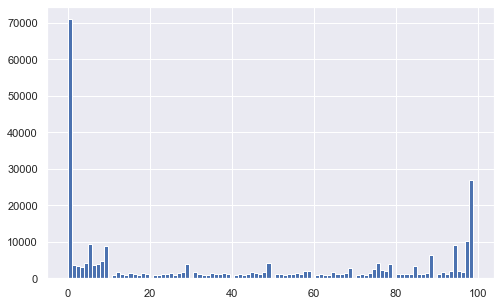

In [16]:
df['Zero_Amount'] = df.Amount == 0
df['Outlier_Amount'] = df.Amount > df.Amount.mean()+df.Amount.std()*2
df['Cents'] = df.Amount.apply(lambda x: int(str(x).split('.')[1]))
df.Cents.hist(bins=100)

<AxesSubplot:xlabel='Amount', ylabel='Density'>

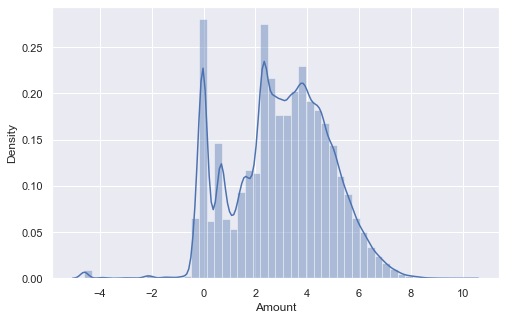

In [18]:
df.Amount[df.Amount!=0] = np.log(df.Amount[df.Amount!=0])
sns.distplot(df.Amount)

### Transaction Time

<AxesSubplot:>

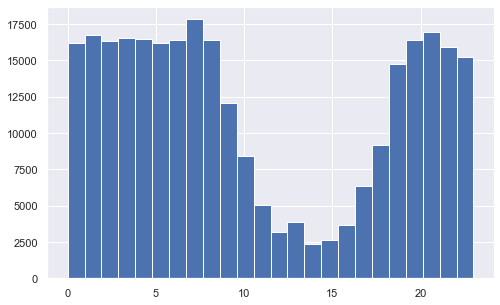

In [47]:
time_df = pd.DataFrame(df.Time)
base_date = datetime.datetime.now()
time_df['Date'] = base_date + time_df.Time.apply(lambda x: datetime.timedelta(seconds=x))
time_df['Hour'] = time_df.Date.apply(lambda x: x.hour)
time_df['Minute'] = time_df.Date.apply(lambda x: x.minute)
time_df['Day'] = (time_df.Time/(60*60*24))//1
time_df.drop(['Time','Date'],axis=1,inplace=True)
time_df.Hour.hist(bins=24)

In [48]:
ohe = OneHotEncoder(sparse=False)
time_df = ohe.fit_transform(time_df.astype(str))
cats = ohe.categories_
labels = ['Hour_' + h for h in cats[0]]
labels += ['Min_' + m for m in cats[1]]
labels += ['Day_' + d for d in cats[2]]
time_df = pd.DataFrame(time_df,columns=labels)

In [54]:
X = df.drop(['Class','Time'],axis=1)
y = df.Class

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)
time_train, time_val = train_test_split(time_df,test_size=0.2,random_state=0)

# Class-Weighted MLP

### Preprocess data

In [56]:
X_train = X_train.join(time_df)
X_val = X_val.join(time_df)
y_train_keras = to_categorical(y_train)
y_val_keras = to_categorical(y_val)
class_weights = {0:1,1:1/y_train.mean()}
sc = StandardScaler()
X_train_keras = sc.fit_transform(X_train)
X_val_keras = sc.fit_transform(X_val)

### Set checkpoint and learning rate scheduler

In [58]:
scheduler = ReduceLROnPlateau(monitor='loss',
                                factor=0.8, 
                                patience=10, 
                                verbose=1,
                                mode='auto', 
                                min_delta=0.0001, 
                                cooldown=0, 
                                min_lr=0)
checkpoint = ModelCheckpoint('checkpoint.best.hdf5',  verbose=1, save_best_only=True, mode='auto')

### Instantiate and compile MLP

In [61]:
nn = models.Sequential()
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(32,activation='relu'))
nn.add(layers.Dense(16,activation='relu'))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(8,activation='relu'))
nn.add(layers.Dense(4,activation='relu'))
nn.add(layers.Dense(2,activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam')

### Train MLP

In [67]:
nn.fit(X_train_keras, 
       y_train_keras, 
       epochs=100, 
       class_weight=class_weights,
       batch_size=512,
       validation_data=(X_val_keras,y_val_keras),
       callbacks=[scheduler,checkpoint])

Train on 227845 samples, validate on 56962 samples
Epoch 00209: val_loss did not improve from 0.05063
Epoch 210/1000
227845/227845 [==============================] - 12s 52us/step - loss: 0.1891 - val_loss: 0.0547

Epoch 00210: val_loss did not improve from 0.05063
Epoch 211/1000
227845/227845 [==============================] - 12s 55us/step - loss: 0.2411 - val_loss: 0.0553

Epoch 00211: val_loss did not improve from 0.05063
Epoch 212/1000
227845/227845 [==============================] - 13s 56us/step - loss: 0.1920 - val_loss: 0.0552

Epoch 00212: val_loss did not improve from 0.05063
Epoch 213/1000
227845/227845 [==============================] - 13s 56us/step - loss: 0.1783 - val_loss: 0.0532

Epoch 00213: val_loss did not improve from 0.05063
Epoch 214/1000
227845/227845 [==============================] - 13s 56us/step - loss: 0.1963 - val_loss: 0.0537

Epoch 00214: val_loss did not improve from 0.05063
Epoch 215/1000
166912/227845 [====================>.........] - ETA: 2s - loss

## Get predictions from checkpoint

In [69]:
results_nn = models.Sequential()
results_nn.add(layers.Dense(64,input_shape=(X_train.shape[1],),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
results_nn.add(layers.Dense(32,activation='relu'))
results_nn.add(layers.Dense(16,activation='relu'))
results_nn.add(layers.Dense(8,activation='relu'))
results_nn.add(layers.Dense(4,activation='relu'))
results_nn.add(layers.Dense(2,activation='sigmoid'))
results_nn.load_weights('checkpoint.best.hdf5')
results_nn.compile(loss='binary_crossentropy',optimizer='adam')

val_preds = results_nn.predict(X_val_keras)
train_preds = results_nn.predict(X_train_keras)

train_results = pd.DataFrame()
val_results = pd.DataFrame()

train_results['mlp'] = train_preds[:,1]
val_results['mlp'] = val_preds[:,1]

# Random Forest with Grid Search on SMOTE data

In [ ]:
rf = RandomForestClassifier()
param_grid = {'max_depth': [3,5,10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200,500]}

smote = SMOTE(n_jobs=-1)
smote_train_X, smote_train_y = smote.fit_resample(X_train,y_train)

search = GridSearchCV(rf, param_grid, cv=3,verbose=1)
search.fit(smote_train_X,smote_train_y)

train_results['smote'] = search.predict_proba(X_train)[:,1]
val_results['smote'] = search.predict_proba(X_val)[:,1]

Fitting 3 folds for each of 81 candidates, totalling 243 fits


# Obtain bagged logistic regression with penalized MLE results

In [ ]:
def get_bagged_PMLE_results(X_train,y_train,functions,function_labels,n_iters=20):
    train = dict.fromkeys(function_labels,np.zeros(X_train.shape[0]))
    val = dict.fromkeys(function_labels,np.zeros(X_val.shape[0]))
    for i in range(iterations):
        print('Epoch', i+1)
        X = X_train[y_train==1].sample(frac=0.05).append(X_train[y_train==0].sample(frac=0.05))
        y = y_train.loc[X.index]
        for j in range(len(functions)):
            function = functions[j]
            label = function_labels[j]
            print(label)
            function.fit(X,y)
            train[label] = (i*train[label] + function.predict_proba(X_train))/(i+1)
            val[label] =  (i*val[label] + function.predict_proba(X_val))/(i+1)
    return train, val

firth = Firth_Logit(num_iters=125,lr=0.05, metric='recall_score', readout_rate=10)
FLIC = Firth_Logit(num_iters=125,lr=0.05,FLIC=True, metric='recall_score', readout_rate=10)
t_firth = Firth_Logit(num_iters=125,lr=0.05,lmbda=0.01, metric='recall_score', readout_rate=10)

functions = [firth,FLIC,t_firth]
function_labels = ['firth','FLIC','t_firth']

firth_train, firth_val = get_bagged_PMLE_results(X_train,y_train,functions,function_labels,iterations=1)
train_results = train_results.join(firth_train)
val_results = val_results.join(firth_val)

# Autoencoder Anomaly Detection
### With undercomplete, regularized and denoising autoencoders using pytorch

## Data Processing

In [56]:
# identify non-fraud rows
normal_inds = y_train[y_train==0].reset_index().index

#Standardize dfs
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.fit_transform(X_val)
n_features = X_train_sc.shape[1]

#Convert non-fraud rows to pytorch tensor
normal_train = X_train_sc[normal_inds,:]
normal_torch = torch.from_numpy(normal_train,).type(torch.FloatTensor)

#Convert train and val sets to pytorch tensor
train_torch = torch.from_numpy(X_train_sc).type(torch.FloatTensor)
val_torch = torch.from_numpy(X_val_sc).type(torch.FloatTensor)

## Create autoencoder class 

In [17]:
class AutoEncoder(nn.Module):
    
    def __init__(self,n_features,hidden_nodes,dropout=None,VAE=False):
        
        '''PARAMETERS
           n_features: number of X variables in dataset
           hidden_nodes: number of nodes in hidden layer
           dropout: fraction of nodes to dropout (0 < dropout <1)'''
        
        super(AutoEncoder, self).__init__()
        self.n_features=n_features
        self.n_hidden = hidden_nodes
        self.encoder = nn.Linear(n_features,hidden_nodes)
        self.decoder = nn.Linear(hidden_nodes,n_features)
        self.output_layer = nn.Linear(n_features,n_features)
        self.dropout = dropout
        self.best_recon = None
        
        
    def forward (self,x):
        if self.dropout!=None:
            x = F.relu(F.dropout(self.encoder(x),p=self.dropout))
        else:
            x = F.relu(self.encoder(x))
        self.hidden_layer=x
        x = F.relu(self.decoder(x))
        x = self.output_layer(x)
        return x
    
    

In [58]:
def train_autoencoder(model, dataset, loss_func, optimizer, epochs=100, batch_size=1024,  
                      validation_tensor=None,y_val=None, lr_rate_scheduler = None, noise_factor=None, 
                      random_seed=None, MSE_stopping_threshold=0):
        '''PARAMETERS
           model: instantiated autoencoder
           dataset: torch tensor of X variables
           loss_func: instantiated loss function
           optimizer: instantiated optimizer
           validation_tensor: torch tensor of validation X variables
           y_val: numpy array of validation y values
           epochs: number of epochs
           lr_rate_scheduler: instantiated PyTorch learning rate scheduler
           batch_size: batch size
           noise_factor: magnitude of noise added to data
             for a denoising autoencoder (0 < noise_factor <=1)
           random_seed: random_seed
           stopping_MSE_threshold: MSE value after which autoencoder stops training'''

        #Set up
        if random_seed!=None:
            torch.manual_seed(random_seed)
        train_loader = torch.utils.data.DataLoader(dataset, 
                                                   batch_size=batch_size, 
                                                   shuffle=True)

        if type(validation_tensor)==torch.Tensor:
            val = True
            val_numpy = validation_tensor.detach().numpy()
        else:
            val = False

        readout_batch_interval = 0.25*(dataset.shape[0]/batch_size)//1
        
        #Training
        for epoch in range(epochs):
            counter = 0
            print('\n\033[1mEpoch {}\033[0m\n'.format(epoch+1))
            for batch in train_loader:

                if noise_factor!=None:
                    batch = batch + noise_factor * torch.randn(*batch.shape)
                batch = torch.autograd.Variable(batch)
                optimizer.zero_grad()
                recon = model(batch)
                loss = loss_func(recon, batch)
                if counter%readout_batch_interval==0:
                    print('Batch {} Loss: {:.4f}'.format(counter, float(loss)))
                loss.backward()
                optimizer.step()
                counter+=1
            
            #Readout for each epoch
            if epoch==0:
                epoch_loss = loss_func(model(dataset), dataset)
                print('\nEPOCH {} LOSS: {:.4f}'.format(epoch+1, float(epoch_loss)))
            else:
                old_epoch_loss = epoch_loss
                epoch_loss = loss_func(model(dataset), dataset)
                print('\nEPOCH {} LOSS: {:.4f}'.format(epoch+1, float(epoch_loss)))
                
            if val == True:
                val_output = model(validation_tensor).detach().numpy()
                reconstruction_error = np.sqrt(np.power(val_output - val_numpy, 2)).sum(axis=1)
                reconstruction_error = sc.fit_transform(reconstruction_error.reshape(-1, 1))
                sklogit = LogisticRegression()
                if epoch==0:
                    sklogit.fit(reconstruction_error,y_val)
                    preds = sklogit.predict(reconstruction_error)
                    score = recall_score(y_val,preds)
                    model.best_recon=model.parameters()
                    model.best_pr = score
                    print('\nReconstruction error recall: {:.4f}'.format(score))
                else:
                    old_score = score
                    sklogit.fit(reconstruction_error,y_val)
                    preds = sklogit.predict(reconstruction_error)
                    score = recall_score(y_val,preds)
                    if score<old_score:
                        model.best_recon=model.parameters()
                        model.best_recall = score
                    print('\nReconstruction error recall {:.4f}'.format(score))
                    print('Change: {:.4f}%'.format(float((score-old_score)/old_score)))
            if type(scheduler)==torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(score) 
            if epoch_loss<=MSE_stopping_threshold:
                break

## Train Autoencoders

### Autoencoder I: Undercomplete with Dropout

#### Instantiate encoder and loss function

In [36]:
ae1 = AutoEncoder(n_features,int(n_features*1.5//1),dropout=0.3)
loss_func = nn.MSELoss()

#### Train autoencoder

In [ ]:
#Start with high learning rate
optimizer = torch.optim.SGD(ae1.parameters(), lr=0.02, momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=4, verbose=True)
train_autoencoder(model=ae1,
                   dataset=normal_torch,
                   loss_func=loss_func,
                   optimizer=optimizer,
                   batch_size=256,
                   epochs=100,
                   lr_rate_scheduler=scheduler,
                   validation_tensor=val_torch,
                   y_val = y_val)

#### Save results

In [39]:
output1 = ae1(normal_torch)
train_output1 = ae1(train_torch)
val_output1 = ae1(val_torch)

### Autoencoder II: L2 Regularization

In [32]:
ae2 = AutoEncoder(n_features,n_features)
loss_func = nn.MSELoss()

In [ ]:
optimizer = torch.optim.RMSprop(ae2.parameters(), lr=0.2, weight_decay=0.25)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae2,
                   dataset=output1,
                   loss_func=loss_func,
                   optimizer=optimizer,
                   batch_size=256,
                   epochs=500,
                   validation_tensor=val_torch,
                   lr_rate_scheduler=scheduler,
                   y_val=y_val)

In [43]:
output2 = ae2(output1)
train_output2 = ae2(train_output1)
val_output2 = ae2(val_output1)

### Autoencoder III: Denoising

In [46]:
ae3 = AutoEncoder(n_features,n_features)
loss_func = nn.MSELoss()

In [ ]:
optimizer = torch.optim.SGD(ae3.parameters(), lr=0.2,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae3,
                  dataset=output2,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=512,
                  epochs=10,
                  noise_factor=0.9,
                  validation_tensor=val_torch,
                  y_val=y_val)

In [48]:
output3 = ae3(output2)
train_output3 = ae3(train_output2)
val_output3 = ae3(val_output2)

### Autoencoder IV: L1 Regularization

In [49]:
ae4 = AutoEncoder(n_features,n_features)

def L1_loss(recon,inputs):
    MSELoss = nn.MSELoss()
    loss = MSELoss(recon,inputs)
    for param in ae4.parameters():
        loss += lmbda*torch.sum(torch.abs(param))
    return loss

loss_func = L1_loss

In [ ]:
lmbda=0.25
optimizer = torch.optim.SGD(ae4.parameters(), lr=0.02,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae4,
                  dataset=output3,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=512,
                  epochs=200,
                  validation_tensor=val_torch,
                  y_val=y_val)

In [53]:
output4 = ae4(output3)
train_output4 = ae4(train_output3)
val_output4 = ae4(val_output3)

### Autoencoder V: Kitchen Sink

In [61]:
ae5 = AutoEncoder(n_features,int(n_features//4),dropout=0.5)
loss_func = L1_loss

In [ ]:
optimizer = torch.optim.RMSprop(ae5.parameters(), lr=0.02, weight_decay=0.5)
train_autoencoder(model=ae5,
                  dataset=output4,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=1024,
                  epochs=200,
                  noise_factor=0.5,
                  validation_tensor=val_torch,
                  y_val=y_val)

In [63]:
output5 = ae5(output4)
train_output5 = ae5(train_output4)
val_output5 = ae5(val_output4)

### Add reconstruction score to DFs

In [69]:
final_train_output = train_output5.detach().numpy()
final_val_output = val_output5.detach().numpy()

#calculate reconstruction score
train_reconstruction_score = np.power(X_train_sc - final_train_output,2).sum(axis=1)
train_reconstruction score = train_reconstruction_score/(train_reconstruction_score.max()-train_reconstruction_score.min())

#normalize
val_reconstruction_score = np.power(X_val_sc - final_val_output,2).sum(axis=1)
val_reconstruction score = val_reconstruction_score/(val_reconstruction_score.max()-val_reconstruction_score.min())

train_results['recon_score'] = train_reconstruction_score
val_results['recon_score'] = val_reconstruction_score

# Run all results through FLIC to obtain final results

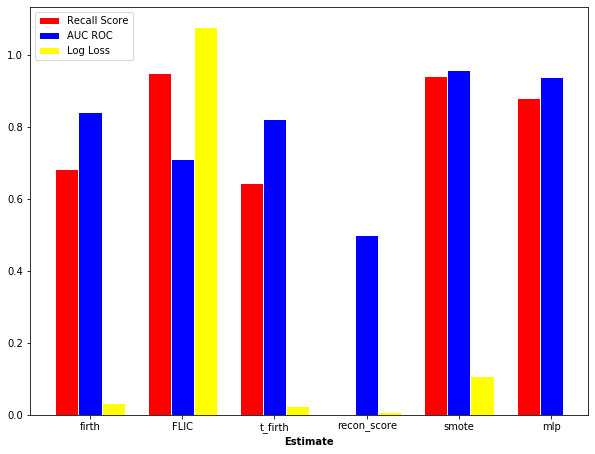

In [47]:
recalls = []
auc_rocs = []
log_losses =[]
for col in val_results.columns:
    recalls.append(recall_score(y_val,val_results[col].round()))
    auc_rocs.append(roc_auc_score(y_val,val_results[col].round()))
    log_losses.append(log_loss(y_val,val_results[col]))
    
estimators = list(val_results.columns)
width = 0.25

plt.figure(figsize=(10,7.5))
r1 = np.arange(len(recalls))
r2 = [i + width for i in r1]
r3 = [i + width for i in r2]

plt.bar(r1, recalls, color='red', width=width, edgecolor='white', label='Recall Score')
plt.bar(r2, auc_rocs, color='blue', width=width, edgecolor='white', label='AUC ROC')
plt.bar(r3, log_losses, color='yellow', width=width, edgecolor='white', label='Log Loss')

plt.xlabel('Estimate', fontweight='bold')
plt.xticks([i + width for i in range(len(recalls))], estimators)
plt.legend()


In [ ]:
FLIC = Firth_Logit(num_iters=100,lr=0.05,FLIC=True, metric='recall_score', readout_rate=10)
train = np.zeros(X_train.shape[0])
val = np.zeros(X_val.shape[0])
for i in range(20):
    print('Epoch:',i+1)
    X = train_results[y_train==1].sample(frac=0.05).append(train_results[y_train==0].sample(frac=0.05))
    y = y_train.loc[X.index]
    FLIC.fit(X,y)
    train = ((i)*train + FLIC.predict_proba(train_results))/(i+1)
    val =  ((i)*val + FLIC.predict_proba(val_results))/(i+1)

# Final validation set area under the ROC curve score

In [41]:
roc_auc_score(y_val,val)

0.9884146871274243